In [29]:
# Require 
import datetime
# import pandas_datareader.data as web
from pandas_datareader import data as web

In [30]:
start= datetime.datetime(2015,1,1)
end= datetime.datetime.today()

aapl = web.DataReader('AAPL', 'yahoo', start, end)
ibm = web.DataReader('IBM', 'yahoo', start, end)
amzn = web.DataReader('AMZN', 'yahoo', start, end)

#Alternative way to download portfolio data:
#aapl = quandl.get('WIKI/AAPL.11',start_date=start,end_date=end)

aapl.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-04-25,163.169998,158.460007,161.119995,162.880005,96046400.0,162.880005
2022-04-26,162.339996,156.720001,162.250000,156.800003,95623200.0,156.800003
2022-04-27,159.789993,155.380005,155.910004,156.570007,88063200.0,156.570007
2022-04-28,164.520004,158.929993,159.250000,163.639999,130216800.0,163.639999
2022-04-29,166.199997,157.250000,161.839996,157.649994,131587100.0,157.649994


Text(0.5, 1.0, 'AMZN')

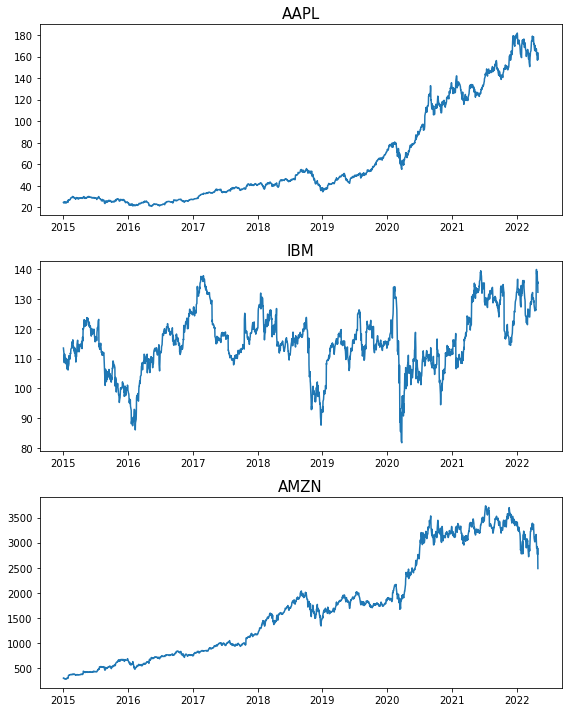

In [31]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 1, sharey=False, tight_layout=True,figsize=(8, 10))
axs[0].plot(aapl['Adj Close'])
axs[0].set_title('AAPL', size = 15)
axs[1].plot(ibm['Adj Close'])
axs[1].set_title('IBM', size = 15)
axs[2].plot(amzn['Adj Close'])
axs[2].set_title('AMZN', size = 15)

In [32]:
#library import
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM

In [33]:
# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(aapl) + 1, 1)

# TAKING DIFFERENT INDICATORS FOR PREDICTION
aapl_adj = aapl["Adj Close"]

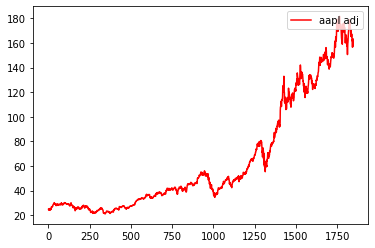

In [34]:
# PLOTTING ALL INDICATORS IN ONE PLOT
plt.plot(obs, aapl_adj, 'r', label = 'aapl adj')
plt.legend(loc = 'upper right')
plt.show()

In [35]:
# PREPARATION OF TIME SERIES DATASE
aapl_adj = np.reshape(aapl_adj.values, (len(aapl_adj),1)) # 1664 rows, 1 column
scaler = MinMaxScaler(feature_range=(0, 1))
aapl_adj = scaler.fit_transform(aapl_adj)

In [36]:
# TRAIN-TEST SPLIT
train_aapl = int(len(aapl_adj) * 0.75)
test_aapl = len(aapl_adj) - train_aapl
train_aapl, test_aapl = aapl_adj[0:train_aapl,:], aapl_adj[train_aapl:len(aapl_adj),:]

In [37]:
def new_dataset(dataset, step_size):
	data_X, data_Y = [], []
	for i in range(len(dataset)-step_size):
		a = dataset[i:(i+step_size), 0]
		data_X.append(a)
		data_Y.append(dataset[i + step_size, 0])
	return np.array(data_X), np.array(data_Y)

In [38]:
# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
step_size = 10
trainX, trainY = new_dataset(train_aapl, step_size)
testX, testY = new_dataset(test_aapl, step_size)

In [39]:
# RESHAPING TRAIN AND TEST DATA
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [40]:
# LSTM MODEL
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

In [41]:
# MODEL COMPILING AND TRAINING
model.compile(loss='mean_squared_error', optimizer='adam') 
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
1373/1373 - 5s - loss: 9.6383e-04 - 5s/epoch - 4ms/step
Epoch 2/10
1373/1373 - 3s - loss: 1.0748e-04 - 3s/epoch - 2ms/step
Epoch 3/10
1373/1373 - 3s - loss: 9.5789e-05 - 3s/epoch - 2ms/step
Epoch 4/10
1373/1373 - 2s - loss: 8.6672e-05 - 2s/epoch - 2ms/step
Epoch 5/10
1373/1373 - 2s - loss: 8.3056e-05 - 2s/epoch - 2ms/step
Epoch 6/10
1373/1373 - 2s - loss: 7.2890e-05 - 2s/epoch - 2ms/step
Epoch 7/10
1373/1373 - 2s - loss: 7.4511e-05 - 2s/epoch - 1ms/step
Epoch 8/10
1373/1373 - 3s - loss: 6.6621e-05 - 3s/epoch - 2ms/step
Epoch 9/10
1373/1373 - 2s - loss: 7.1648e-05 - 2s/epoch - 2ms/step
Epoch 10/10
1373/1373 - 2s - loss: 7.1965e-05 - 2s/epoch - 2ms/step


In [42]:
# PREDICTION
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [43]:
# DE-NORMALIZING FOR PLOTTING
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [44]:
# TRAINING RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))
# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

Train RMSE: 1.31
Test RMSE: 16.03


In [45]:
# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(aapl_adj)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

In [46]:
# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(aapl_adj)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2):len(aapl_adj), :] = testPredict

In [47]:
# DE-NORMALIZING MAIN DATASET 
aapl_adj = scaler.inverse_transform(aapl_adj)

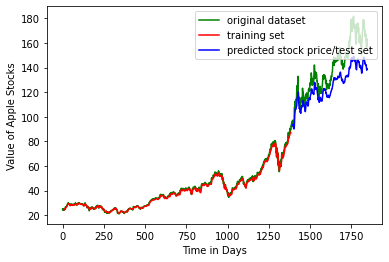

In [48]:
# PLOT OF MAIN aapl VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.plot(aapl_adj, 'g', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('Value of Apple Stocks')
plt.show()

In [49]:
aapl_adj1= aapl_adj[-50:,:]
trainPredictPlot1 = trainPredictPlot[-50:,:]
testPredictPlot1 = testPredictPlot[-50:,:]

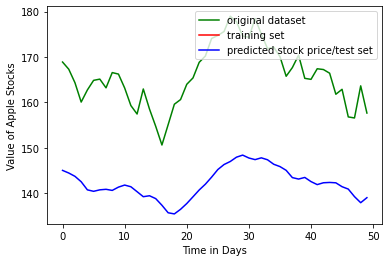

In [50]:
plt.plot(aapl_adj1, 'g', label = 'original dataset')
plt.plot(trainPredictPlot1, 'r', label = 'training set')
plt.plot(testPredictPlot1, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('Value of Apple Stocks')
plt.show()

In [51]:
last_val = testPredict[-11:-1]
last_val1 = scaler.fit_transform(last_val)
next_val = model.predict(np.reshape(last_val1, (1,1,10)))
next_val1=scaler.inverse_transform(next_val)
print ("Last 10 Day Value:", last_val)
print ("Next Day Value:", np.asscalar(next_val1))

Last 10 Day Value: [[143.47939]
 [142.56468]
 [141.90294]
 [142.30693]
 [142.37752]
 [142.29596]
 [141.44032]
 [140.91676]
 [139.25778]
 [137.91823]]
Next Day Value: 139.28335571289062


<ipython-input-51-fcdaa90ee3c1>:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  print ("Next Day Value:", np.asscalar(next_val1))
